In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import random
import os
from tqdm import tqdm


In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),  # Standard CIFAR-10 normalization
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])


train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [3]:
class SubsetWithTargets(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        return image, label, self.indices[idx]

    def __len__(self):
        return len(self.indices)

def collate_fn_with_index(batch):
    images, labels, indices = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    indices = torch.tensor(indices)
    return images, labels, indices

In [4]:
def get_model():
    model = torchvision.models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model


In [5]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for x, y, _ in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


In [6]:
def get_probs(model, dataloader, device):
    model.eval()
    probs, indices = [], []
    with torch.no_grad():
        for x, _, idx in dataloader:
            x = x.to(device)
            out = F.softmax(model(x), dim=1)
            probs.append(out.cpu())
            indices.extend(idx)
    return torch.cat(probs), indices

def query_samples(strategy, model, unlabeled_loader, already_selected, budget, device):
    probs, indices = get_probs(model, unlabeled_loader, device)

    if strategy == 'random':
        candidates = list(set(indices) - set(already_selected))
        return random.sample(candidates, budget)

    elif strategy == 'least_confident':
        scores = 1 - probs.max(dim=1)[0]
    elif strategy == 'margin':
        top2 = torch.topk(probs, 2, dim=1).values
        scores = top2[:,0] - top2[:,1]
    elif strategy == 'entropy':
        scores = -torch.sum(probs * probs.log(), dim=1)
    elif strategy == 'density':
        embeddings = probs.numpy()
        dist = pairwise_distances(embeddings, embeddings)
        scores = -dist.mean(axis=1)
    elif strategy == 'diversity':
        embeddings = probs.numpy()
        kmeans = KMeans(n_clusters=budget)
        kmeans.fit(embeddings)
        _, closest = pairwise_distances(embeddings, kmeans.cluster_centers_).min(axis=1), \
                     pairwise_distances(embeddings, kmeans.cluster_centers_).argmin(axis=1)
        selected = np.unique(closest)
        return [indices[i] for i in selected[:budget]]
    else:
        raise ValueError("Unknown strategy:", strategy)

    topk = torch.topk(scores, budget).indices
    return [indices[i] for i in topk]


In [7]:
def plot_metrics(train_accs, val_accs, train_losses, val_losses, round_num, strategy):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title(f'Accuracy after round {round_num} - {strategy}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Loss after round {round_num} - {strategy}')
    plt.legend()
    plt.show()


In [10]:
def active_learning_loop(strategy='random', init_size=2000, query_size=2000, rounds=5, batch_size=64):
    epochs = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    all_indices = list(range(len(train_data)))
    np.random.seed(42)
    initial_labeled = np.random.choice(all_indices, init_size, replace=False).tolist()
    labeled_indices = initial_labeled.copy()
    unlabeled_indices = list(set(all_indices) - set(labeled_indices))

    labeled_set = SubsetWithTargets(train_data, labeled_indices)
    unlabeled_set = SubsetWithTargets(train_data, unlabeled_indices)

    val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    acc_history, sample_counts = [], []

    for round in range(rounds):
        print(f"\n🌀 Round {round+1} - Strategy: {strategy}")
        model = get_model().to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_with_index)

        train_accs, val_accs, train_losses, val_losses = [], [], [], []
        for epoch in range(epochs):
            train_loss, train_acc = train(model, labeled_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

        acc_history.append(val_acc)
        sample_counts.append(len(labeled_set))
        plot_metrics(train_accs, val_accs, train_losses, val_losses, round+1, strategy)

        # Select new samples
        if round < rounds - 1:
            unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_with_index)
            selected = query_samples(strategy, model, unlabeled_loader, labeled_indices, query_size, device)
            labeled_indices.extend(selected)
            unlabeled_indices = list(set(unlabeled_indices) - set(selected))
            labeled_set = SubsetWithTargets(train_data, labeled_indices)
            unlabeled_set = SubsetWithTargets(train_data, unlabeled_indices)

    # Final plot: Accuracy vs. Number of labeled samples
    plt.figure(figsize=(8, 5))
    plt.plot(sample_counts, acc_history, marker='o')
    plt.title(f'Final Accuracy vs. Number of Labeled Samples - {strategy}')
    plt.xlabel('Number of Labeled Samples')
    plt.ylabel('Validation Accuracy')
    plt.grid()
    plt.show()

    return {'strategy': strategy, 'acc_history': acc_history, 'sample_counts': sample_counts}


Running strategy: random

🌀 Round 1 - Strategy: random
Epoch 1: Train Acc=0.121, Val Acc=0.198
Epoch 2: Train Acc=0.188, Val Acc=0.235
Epoch 3: Train Acc=0.260, Val Acc=0.244
Epoch 4: Train Acc=0.285, Val Acc=0.277
Epoch 5: Train Acc=0.307, Val Acc=0.296
Epoch 6: Train Acc=0.301, Val Acc=0.303
Epoch 7: Train Acc=0.311, Val Acc=0.301
Epoch 8: Train Acc=0.320, Val Acc=0.303
Epoch 9: Train Acc=0.304, Val Acc=0.309
Epoch 10: Train Acc=0.323, Val Acc=0.318


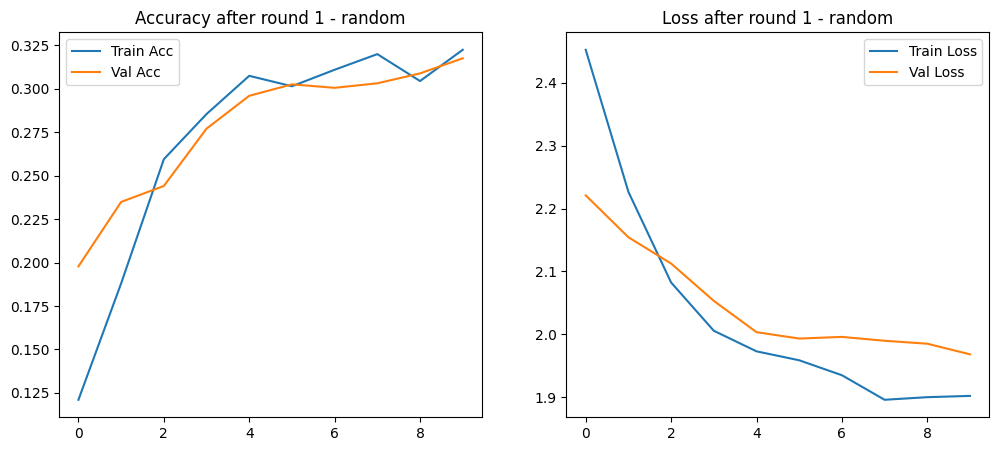


🌀 Round 2 - Strategy: random
Epoch 1: Train Acc=0.173, Val Acc=0.259
Epoch 2: Train Acc=0.258, Val Acc=0.281
Epoch 3: Train Acc=0.287, Val Acc=0.309
Epoch 4: Train Acc=0.310, Val Acc=0.316
Epoch 5: Train Acc=0.312, Val Acc=0.328
Epoch 6: Train Acc=0.322, Val Acc=0.323
Epoch 7: Train Acc=0.336, Val Acc=0.337
Epoch 8: Train Acc=0.336, Val Acc=0.338
Epoch 9: Train Acc=0.337, Val Acc=0.335
Epoch 10: Train Acc=0.338, Val Acc=0.334


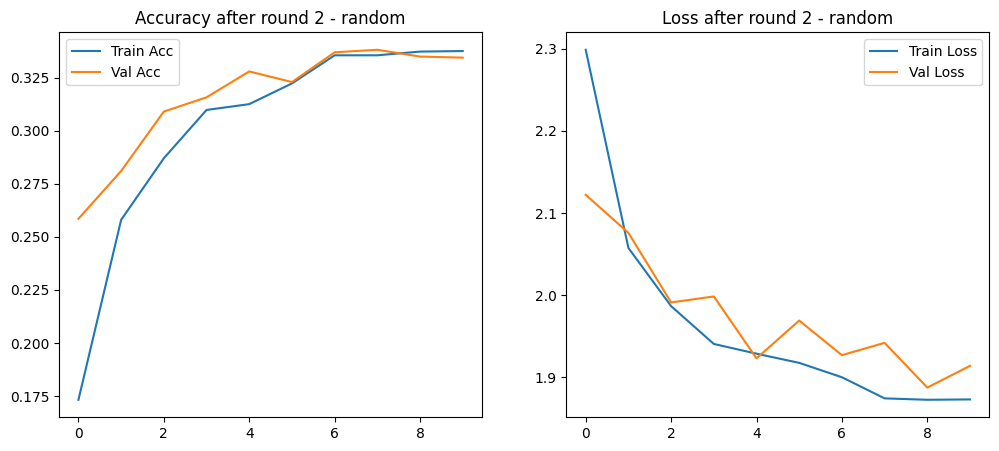


🌀 Round 3 - Strategy: random
Epoch 1: Train Acc=0.203, Val Acc=0.261
Epoch 2: Train Acc=0.273, Val Acc=0.286
Epoch 3: Train Acc=0.303, Val Acc=0.299
Epoch 4: Train Acc=0.310, Val Acc=0.313
Epoch 5: Train Acc=0.324, Val Acc=0.334
Epoch 6: Train Acc=0.335, Val Acc=0.327
Epoch 7: Train Acc=0.328, Val Acc=0.313
Epoch 8: Train Acc=0.331, Val Acc=0.315
Epoch 9: Train Acc=0.341, Val Acc=0.327
Epoch 10: Train Acc=0.339, Val Acc=0.330


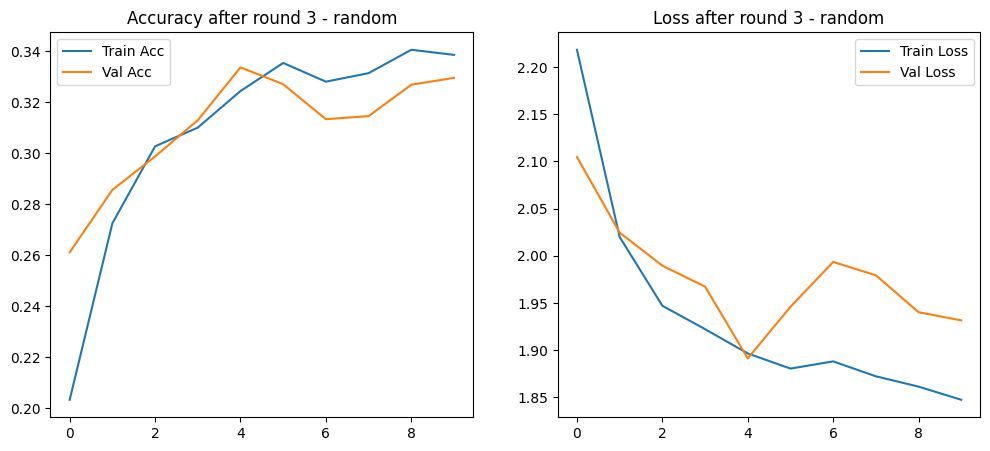


🌀 Round 4 - Strategy: random
Epoch 1: Train Acc=0.224, Val Acc=0.278
Epoch 2: Train Acc=0.298, Val Acc=0.298
Epoch 3: Train Acc=0.313, Val Acc=0.302
Epoch 4: Train Acc=0.325, Val Acc=0.324
Epoch 5: Train Acc=0.332, Val Acc=0.321
Epoch 6: Train Acc=0.335, Val Acc=0.333
Epoch 7: Train Acc=0.336, Val Acc=0.333
Epoch 8: Train Acc=0.344, Val Acc=0.337
Epoch 9: Train Acc=0.336, Val Acc=0.345
Epoch 10: Train Acc=0.336, Val Acc=0.344


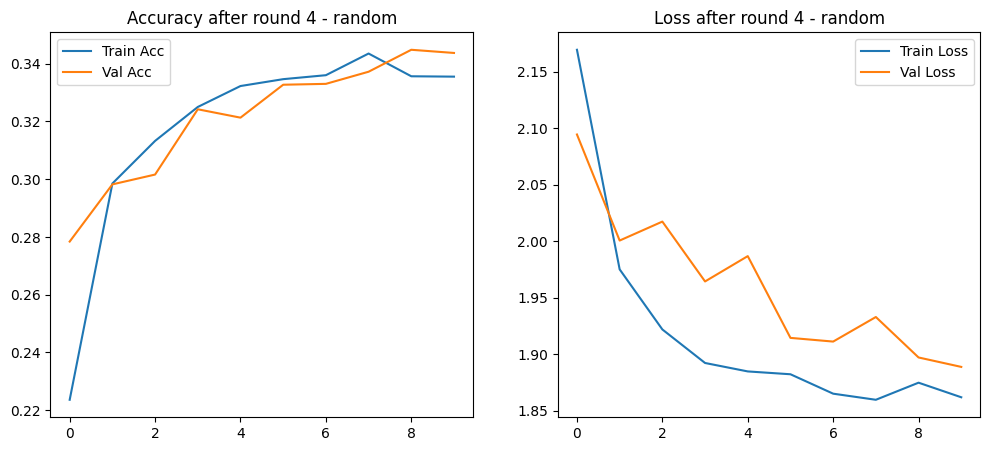


🌀 Round 5 - Strategy: random
Epoch 1: Train Acc=0.230, Val Acc=0.304
Epoch 2: Train Acc=0.314, Val Acc=0.328
Epoch 3: Train Acc=0.331, Val Acc=0.331
Epoch 4: Train Acc=0.327, Val Acc=0.326
Epoch 5: Train Acc=0.335, Val Acc=0.344
Epoch 6: Train Acc=0.337, Val Acc=0.337
Epoch 7: Train Acc=0.337, Val Acc=0.347
Epoch 8: Train Acc=0.343, Val Acc=0.352
Epoch 9: Train Acc=0.342, Val Acc=0.348
Epoch 10: Train Acc=0.345, Val Acc=0.358


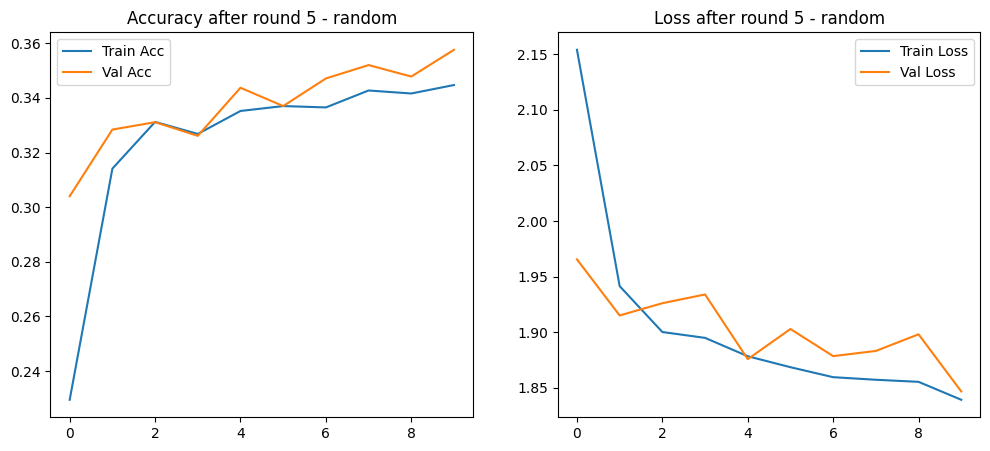

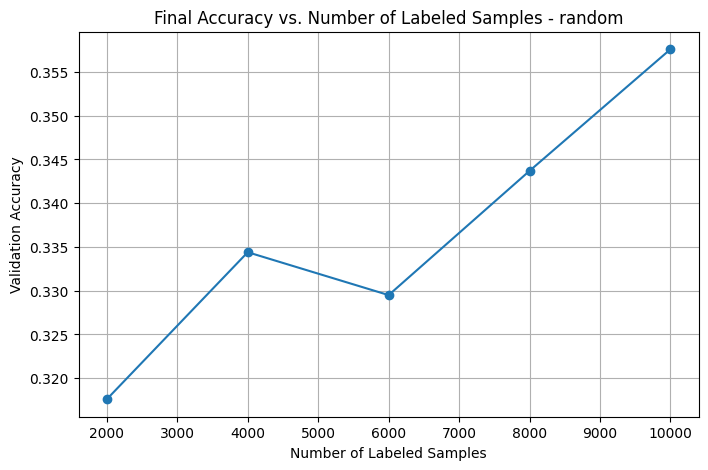

Running strategy: entropy

🌀 Round 1 - Strategy: entropy
Epoch 1: Train Acc=0.134, Val Acc=0.189
Epoch 2: Train Acc=0.224, Val Acc=0.235
Epoch 3: Train Acc=0.258, Val Acc=0.264
Epoch 4: Train Acc=0.267, Val Acc=0.290
Epoch 5: Train Acc=0.274, Val Acc=0.288
Epoch 6: Train Acc=0.304, Val Acc=0.299
Epoch 7: Train Acc=0.298, Val Acc=0.298
Epoch 8: Train Acc=0.304, Val Acc=0.308
Epoch 9: Train Acc=0.335, Val Acc=0.303
Epoch 10: Train Acc=0.321, Val Acc=0.315


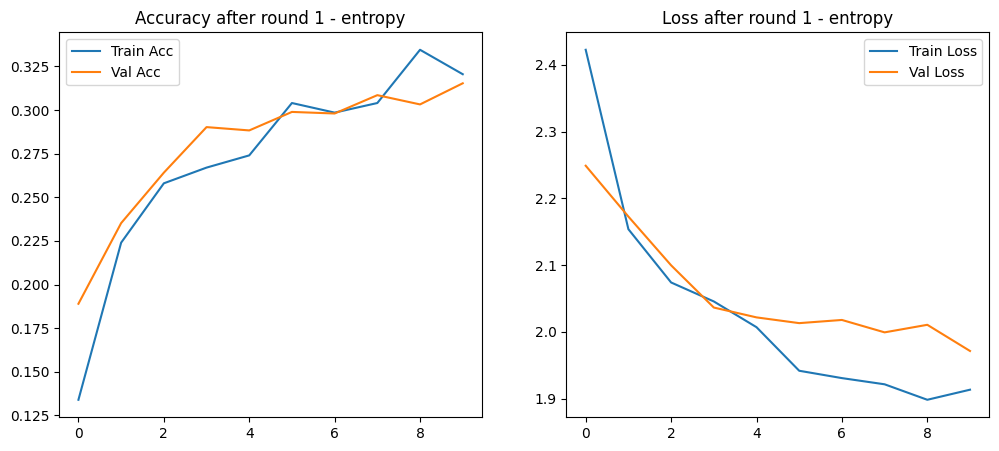


🌀 Round 2 - Strategy: entropy
Epoch 1: Train Acc=0.168, Val Acc=0.239
Epoch 2: Train Acc=0.246, Val Acc=0.272
Epoch 3: Train Acc=0.281, Val Acc=0.296
Epoch 4: Train Acc=0.287, Val Acc=0.311
Epoch 5: Train Acc=0.284, Val Acc=0.302
Epoch 6: Train Acc=0.294, Val Acc=0.325
Epoch 7: Train Acc=0.296, Val Acc=0.325
Epoch 8: Train Acc=0.307, Val Acc=0.330
Epoch 9: Train Acc=0.306, Val Acc=0.324
Epoch 10: Train Acc=0.310, Val Acc=0.338


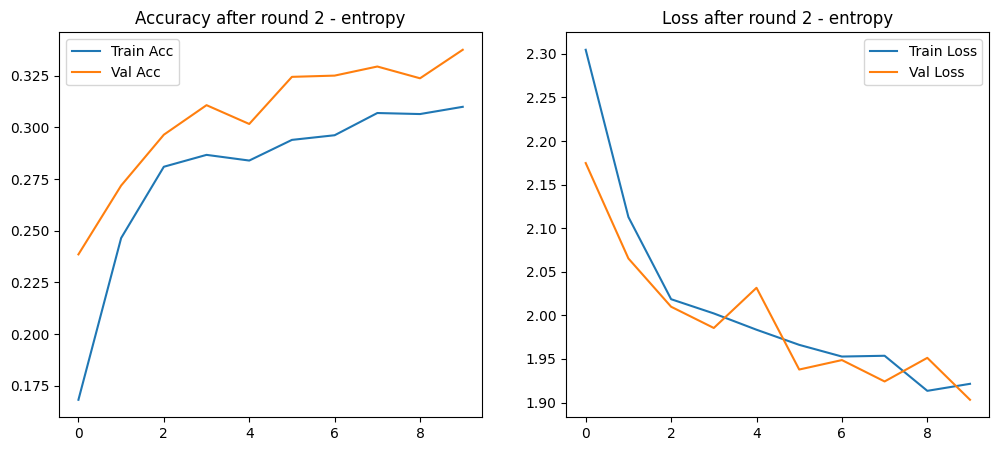


🌀 Round 3 - Strategy: entropy
Epoch 1: Train Acc=0.175, Val Acc=0.270
Epoch 2: Train Acc=0.254, Val Acc=0.309
Epoch 3: Train Acc=0.281, Val Acc=0.335
Epoch 4: Train Acc=0.291, Val Acc=0.331
Epoch 5: Train Acc=0.286, Val Acc=0.344
Epoch 6: Train Acc=0.306, Val Acc=0.333
Epoch 7: Train Acc=0.303, Val Acc=0.342
Epoch 8: Train Acc=0.308, Val Acc=0.344
Epoch 9: Train Acc=0.326, Val Acc=0.336
Epoch 10: Train Acc=0.305, Val Acc=0.333


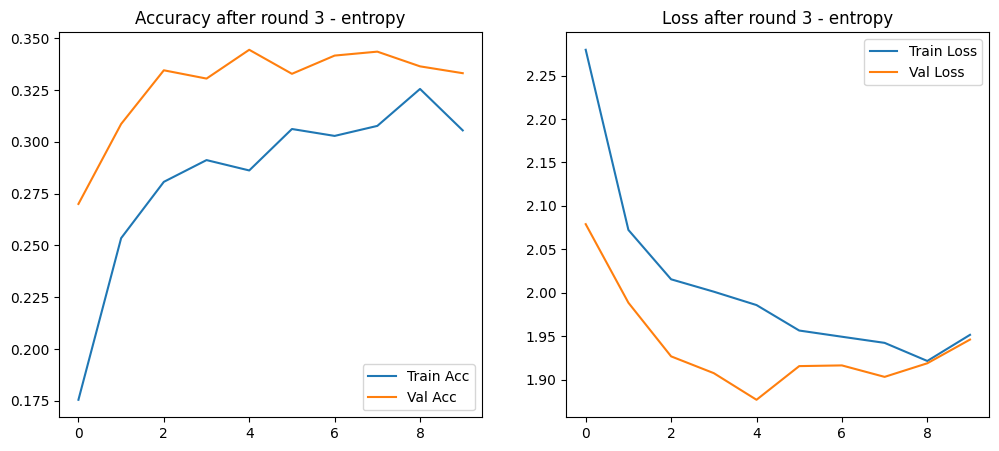


🌀 Round 4 - Strategy: entropy
Epoch 1: Train Acc=0.196, Val Acc=0.281
Epoch 2: Train Acc=0.269, Val Acc=0.304
Epoch 3: Train Acc=0.275, Val Acc=0.315
Epoch 4: Train Acc=0.281, Val Acc=0.333
Epoch 5: Train Acc=0.300, Val Acc=0.344
Epoch 6: Train Acc=0.287, Val Acc=0.341
Epoch 7: Train Acc=0.294, Val Acc=0.354
Epoch 8: Train Acc=0.302, Val Acc=0.343
Epoch 9: Train Acc=0.305, Val Acc=0.338
Epoch 10: Train Acc=0.310, Val Acc=0.348


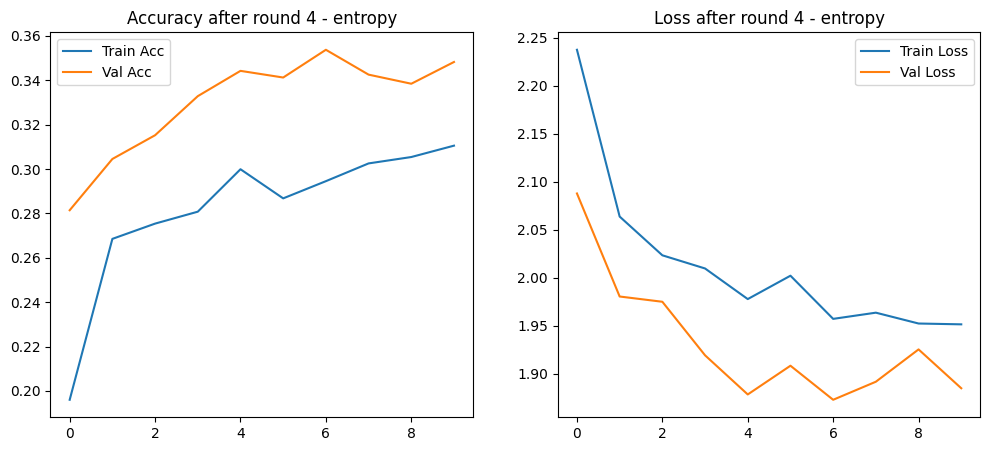


🌀 Round 5 - Strategy: entropy
Epoch 1: Train Acc=0.200, Val Acc=0.292
Epoch 2: Train Acc=0.258, Val Acc=0.327
Epoch 3: Train Acc=0.279, Val Acc=0.344
Epoch 4: Train Acc=0.287, Val Acc=0.333
Epoch 5: Train Acc=0.289, Val Acc=0.353
Epoch 6: Train Acc=0.295, Val Acc=0.339
Epoch 7: Train Acc=0.300, Val Acc=0.347
Epoch 8: Train Acc=0.298, Val Acc=0.342
Epoch 9: Train Acc=0.297, Val Acc=0.344
Epoch 10: Train Acc=0.296, Val Acc=0.352


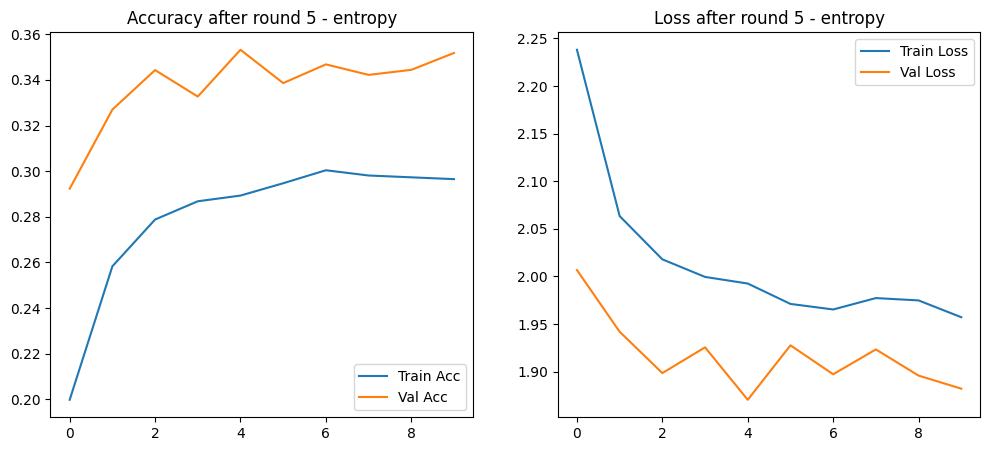

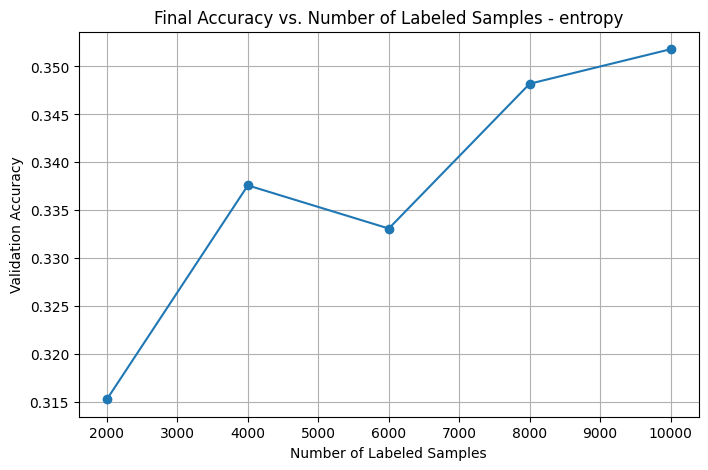

Running strategy: margin

🌀 Round 1 - Strategy: margin
Epoch 1: Train Acc=0.134, Val Acc=0.217
Epoch 2: Train Acc=0.224, Val Acc=0.244
Epoch 3: Train Acc=0.251, Val Acc=0.268
Epoch 4: Train Acc=0.278, Val Acc=0.291
Epoch 5: Train Acc=0.297, Val Acc=0.293
Epoch 6: Train Acc=0.319, Val Acc=0.299
Epoch 7: Train Acc=0.307, Val Acc=0.301
Epoch 8: Train Acc=0.327, Val Acc=0.301
Epoch 9: Train Acc=0.329, Val Acc=0.308
Epoch 10: Train Acc=0.336, Val Acc=0.322


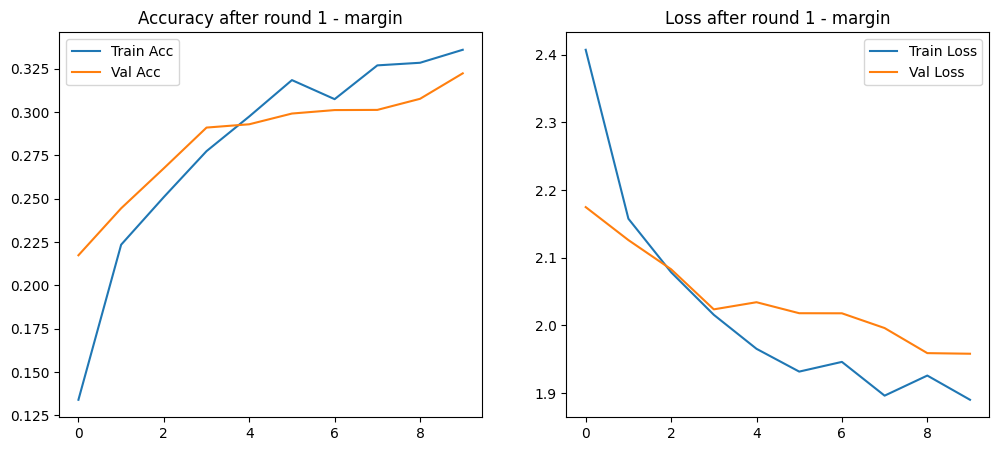


🌀 Round 2 - Strategy: margin
Epoch 1: Train Acc=0.217, Val Acc=0.253
Epoch 2: Train Acc=0.338, Val Acc=0.293
Epoch 3: Train Acc=0.356, Val Acc=0.306
Epoch 4: Train Acc=0.384, Val Acc=0.296
Epoch 5: Train Acc=0.381, Val Acc=0.319
Epoch 6: Train Acc=0.395, Val Acc=0.314
Epoch 7: Train Acc=0.394, Val Acc=0.321
Epoch 8: Train Acc=0.406, Val Acc=0.321
Epoch 9: Train Acc=0.396, Val Acc=0.328
Epoch 10: Train Acc=0.404, Val Acc=0.331


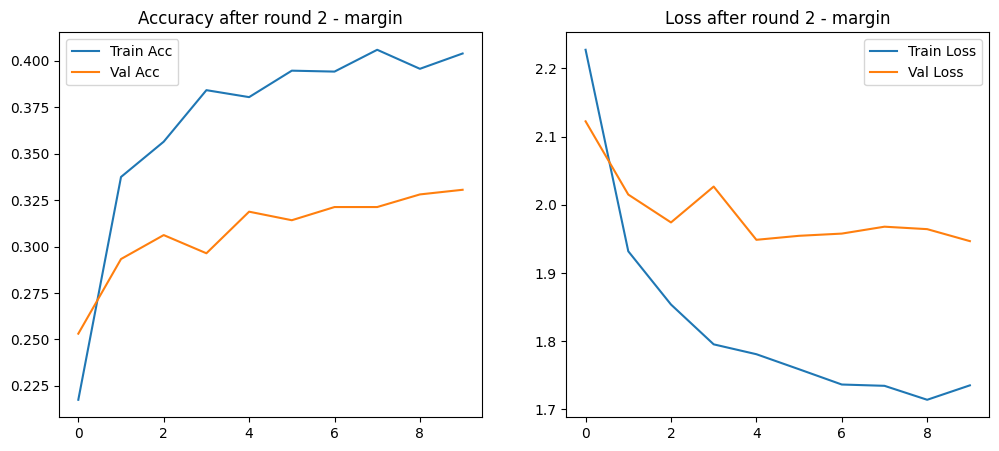


🌀 Round 3 - Strategy: margin
Epoch 1: Train Acc=0.283, Val Acc=0.264
Epoch 2: Train Acc=0.400, Val Acc=0.290
Epoch 3: Train Acc=0.426, Val Acc=0.315
Epoch 4: Train Acc=0.419, Val Acc=0.304
Epoch 5: Train Acc=0.427, Val Acc=0.324
Epoch 6: Train Acc=0.434, Val Acc=0.317
Epoch 7: Train Acc=0.440, Val Acc=0.343
Epoch 8: Train Acc=0.443, Val Acc=0.331
Epoch 9: Train Acc=0.438, Val Acc=0.322
Epoch 10: Train Acc=0.444, Val Acc=0.330


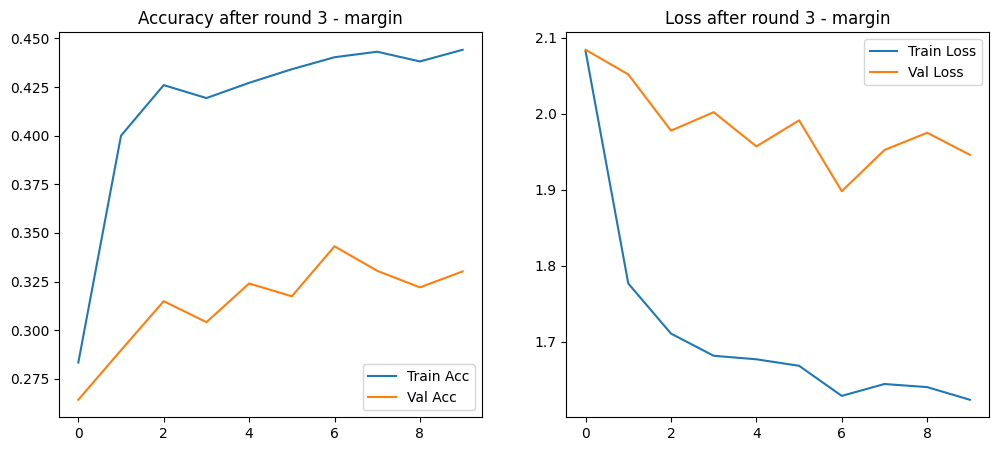


🌀 Round 4 - Strategy: margin
Epoch 1: Train Acc=0.339, Val Acc=0.286
Epoch 2: Train Acc=0.432, Val Acc=0.318
Epoch 3: Train Acc=0.449, Val Acc=0.294
Epoch 4: Train Acc=0.460, Val Acc=0.315
Epoch 5: Train Acc=0.465, Val Acc=0.330
Epoch 6: Train Acc=0.466, Val Acc=0.343
Epoch 7: Train Acc=0.463, Val Acc=0.326
Epoch 8: Train Acc=0.475, Val Acc=0.341
Epoch 9: Train Acc=0.473, Val Acc=0.337
Epoch 10: Train Acc=0.474, Val Acc=0.336


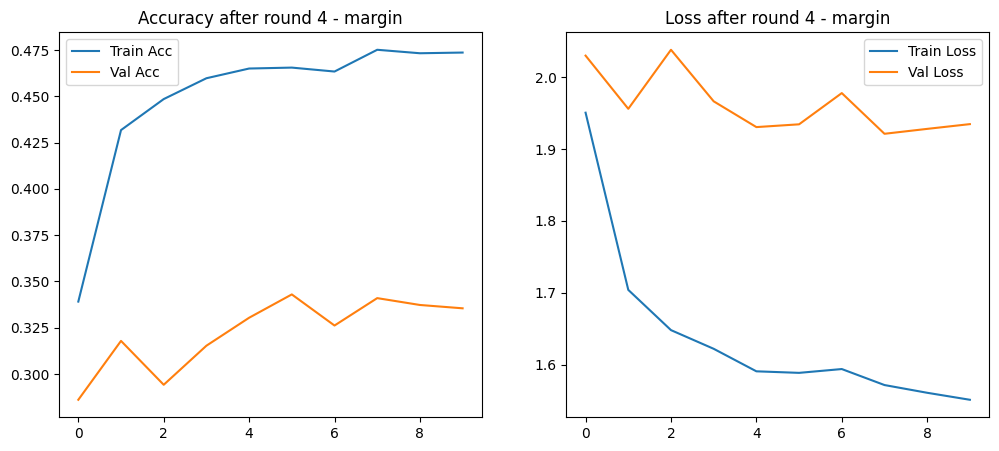


🌀 Round 5 - Strategy: margin
Epoch 1: Train Acc=0.369, Val Acc=0.280
Epoch 2: Train Acc=0.457, Val Acc=0.311
Epoch 3: Train Acc=0.480, Val Acc=0.311
Epoch 4: Train Acc=0.478, Val Acc=0.314
Epoch 5: Train Acc=0.491, Val Acc=0.335
Epoch 6: Train Acc=0.485, Val Acc=0.327
Epoch 7: Train Acc=0.490, Val Acc=0.344
Epoch 8: Train Acc=0.495, Val Acc=0.338
Epoch 9: Train Acc=0.496, Val Acc=0.335
Epoch 10: Train Acc=0.492, Val Acc=0.333


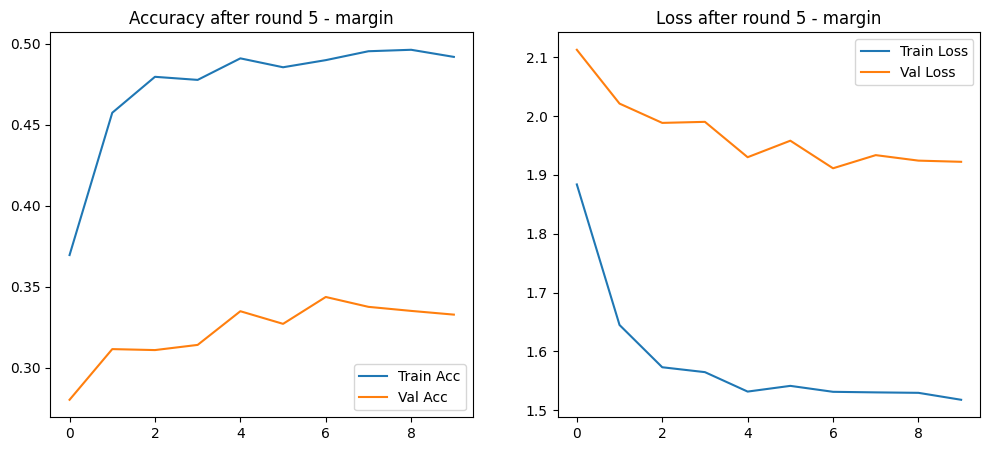

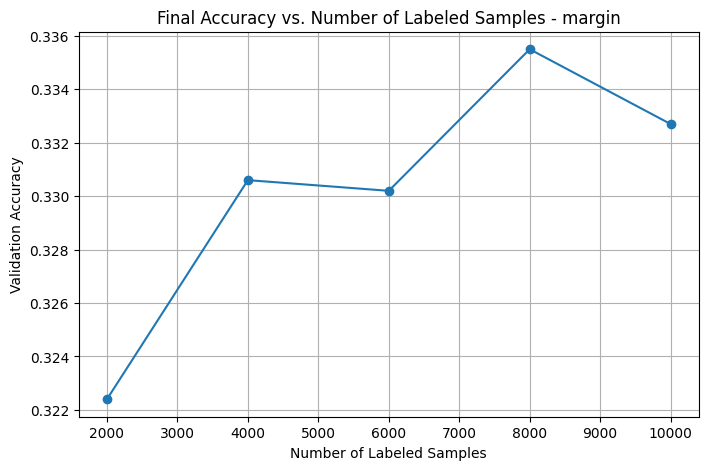

Running strategy: least_confident

🌀 Round 1 - Strategy: least_confident
Epoch 1: Train Acc=0.130, Val Acc=0.212
Epoch 2: Train Acc=0.225, Val Acc=0.245
Epoch 3: Train Acc=0.252, Val Acc=0.269
Epoch 4: Train Acc=0.269, Val Acc=0.275
Epoch 5: Train Acc=0.296, Val Acc=0.289
Epoch 6: Train Acc=0.301, Val Acc=0.302
Epoch 7: Train Acc=0.317, Val Acc=0.318
Epoch 8: Train Acc=0.325, Val Acc=0.303
Epoch 9: Train Acc=0.314, Val Acc=0.317
Epoch 10: Train Acc=0.310, Val Acc=0.324


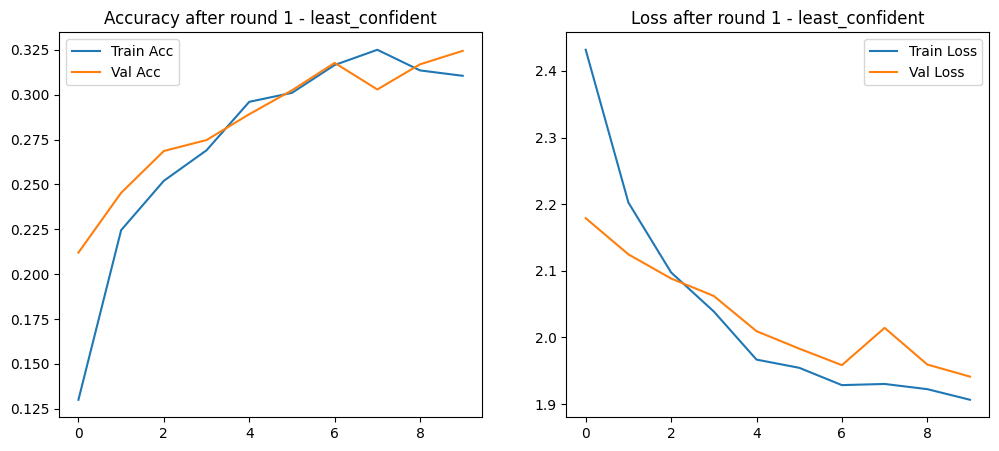


🌀 Round 2 - Strategy: least_confident
Epoch 1: Train Acc=0.166, Val Acc=0.247
Epoch 2: Train Acc=0.242, Val Acc=0.270
Epoch 3: Train Acc=0.265, Val Acc=0.294
Epoch 4: Train Acc=0.278, Val Acc=0.297
Epoch 5: Train Acc=0.285, Val Acc=0.302
Epoch 6: Train Acc=0.293, Val Acc=0.323
Epoch 7: Train Acc=0.287, Val Acc=0.330
Epoch 8: Train Acc=0.308, Val Acc=0.326
Epoch 9: Train Acc=0.315, Val Acc=0.338
Epoch 10: Train Acc=0.305, Val Acc=0.336


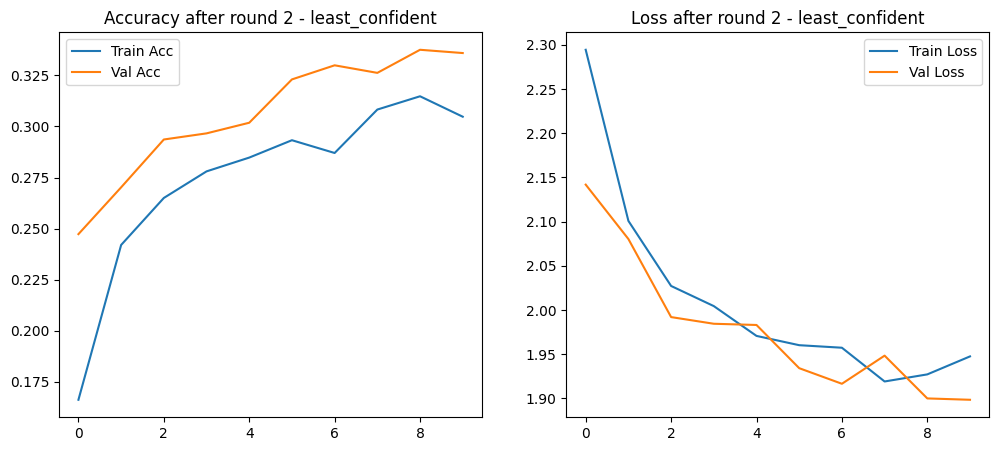


🌀 Round 3 - Strategy: least_confident
Epoch 1: Train Acc=0.171, Val Acc=0.265
Epoch 2: Train Acc=0.248, Val Acc=0.299
Epoch 3: Train Acc=0.271, Val Acc=0.319
Epoch 4: Train Acc=0.281, Val Acc=0.335
Epoch 5: Train Acc=0.289, Val Acc=0.334
Epoch 6: Train Acc=0.292, Val Acc=0.334
Epoch 7: Train Acc=0.303, Val Acc=0.351
Epoch 8: Train Acc=0.300, Val Acc=0.330
Epoch 9: Train Acc=0.313, Val Acc=0.339
Epoch 10: Train Acc=0.302, Val Acc=0.353


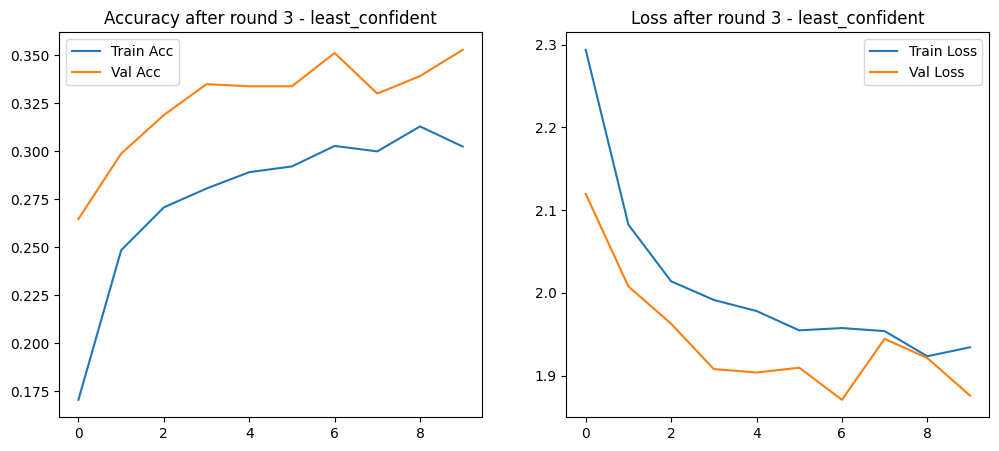


🌀 Round 4 - Strategy: least_confident
Epoch 1: Train Acc=0.192, Val Acc=0.285
Epoch 2: Train Acc=0.262, Val Acc=0.314
Epoch 3: Train Acc=0.283, Val Acc=0.323
Epoch 4: Train Acc=0.279, Val Acc=0.336
Epoch 5: Train Acc=0.290, Val Acc=0.326
Epoch 6: Train Acc=0.293, Val Acc=0.338
Epoch 7: Train Acc=0.305, Val Acc=0.339
Epoch 8: Train Acc=0.302, Val Acc=0.351
Epoch 9: Train Acc=0.301, Val Acc=0.339
Epoch 10: Train Acc=0.310, Val Acc=0.350


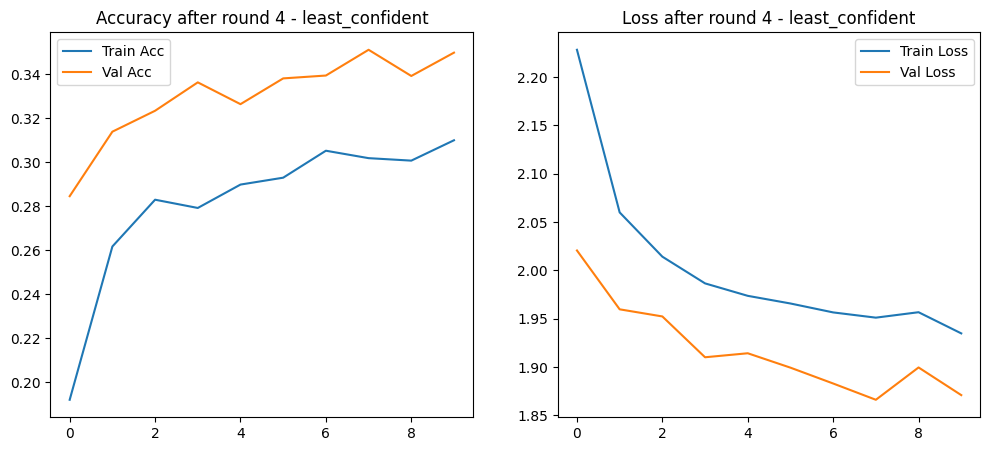


🌀 Round 5 - Strategy: least_confident
Epoch 1: Train Acc=0.202, Val Acc=0.287
Epoch 2: Train Acc=0.256, Val Acc=0.318
Epoch 3: Train Acc=0.273, Val Acc=0.327
Epoch 4: Train Acc=0.279, Val Acc=0.322
Epoch 5: Train Acc=0.287, Val Acc=0.341
Epoch 6: Train Acc=0.298, Val Acc=0.327
Epoch 7: Train Acc=0.292, Val Acc=0.323
Epoch 8: Train Acc=0.300, Val Acc=0.351
Epoch 9: Train Acc=0.300, Val Acc=0.352
Epoch 10: Train Acc=0.304, Val Acc=0.352


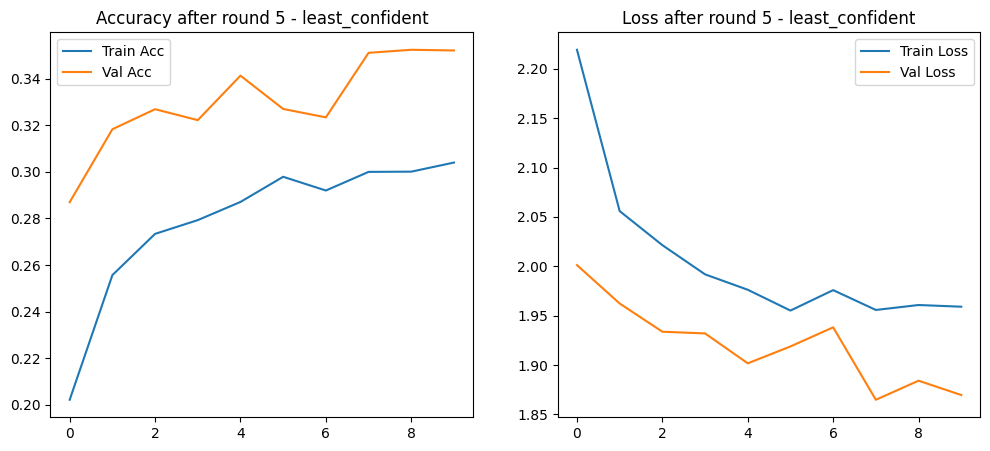

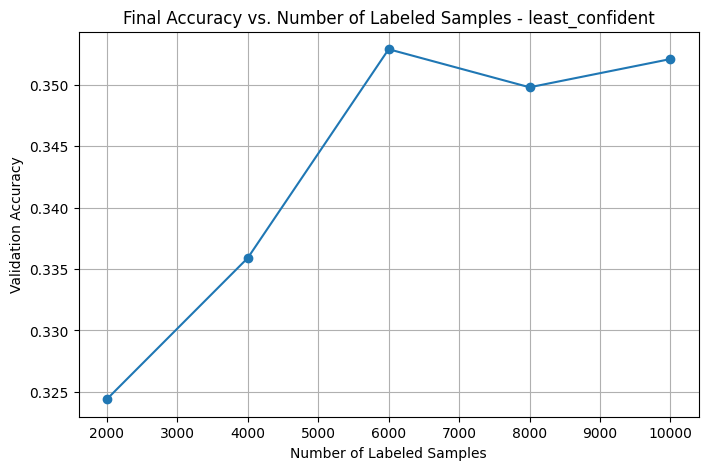

Running strategy: density

🌀 Round 1 - Strategy: density
Epoch 1: Train Acc=0.140, Val Acc=0.216
Epoch 2: Train Acc=0.226, Val Acc=0.264
Epoch 3: Train Acc=0.251, Val Acc=0.285
Epoch 4: Train Acc=0.291, Val Acc=0.305
Epoch 5: Train Acc=0.299, Val Acc=0.301
Epoch 6: Train Acc=0.288, Val Acc=0.316
Epoch 7: Train Acc=0.329, Val Acc=0.318
Epoch 8: Train Acc=0.317, Val Acc=0.324
Epoch 9: Train Acc=0.326, Val Acc=0.304
Epoch 10: Train Acc=0.320, Val Acc=0.319


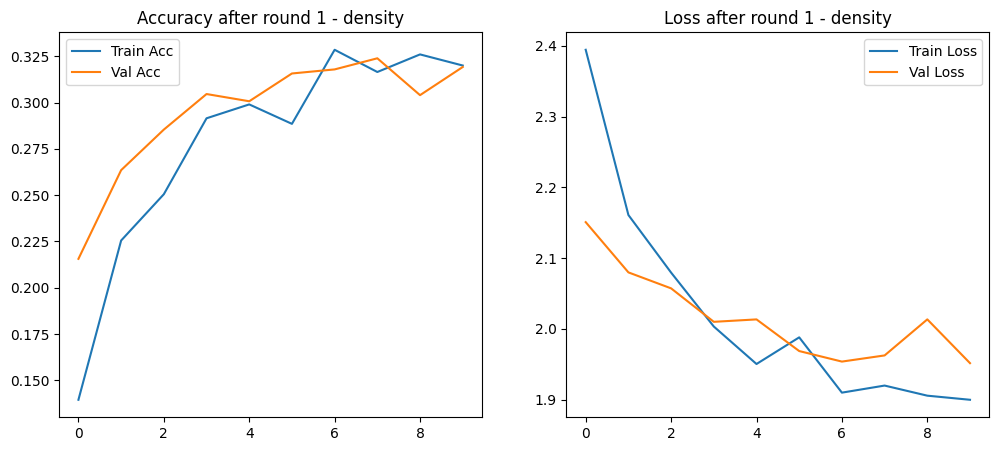

In [ ]:
all_results = {}
strategies = ['random', 'entropy', 'margin', 'least_confident', 'density', 'diversity']

for strat in strategies:
    print(f"Running strategy: {strat}")
    result = active_learning_loop(strategy=strat)
    all_results[strat] = {
        'acc_history': result['acc_history'],
        'sample_counts': result['sample_counts']
    }



In [3]:
plt.figure(figsize=(10, 6))
for strat, data in all_results.items():
    plt.plot(data['sample_counts'], data['acc_history'], marker='o', label=strat)
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Validation Accuracy')
plt.title('Active Learning Strategy Comparison')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'all_results' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pprint
pprint.pprint(all_results)
